In [4]:
import sys
!conda install --yes --prefix {sys.prefix} tqdm
!conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... done

## Package Plan ##

  environment location: F:\Anaconda3

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         158 KB
    certifi-2019.3.9           |           py36_0         156 KB
    cryptography-2.6.1         |   py36h7a1dbc1_0         563 KB
    kiwisolver-1.0.1           |   py36h6538335_0          61 KB
    krb5-1.16.1                |       hc04afaa_7         819 KB
    libcurl-7.64.0             |       h2a8f88b_2         283 KB
    libpng-1.6.36              |       h2a8f88b_0         550 KB
    openssl-1.1.1b             |       he774522_1         5.7 MB
    pycurl-7.43.0.2            |   py36h7a1dbc1_0         182 KB
    pyqt-5.9.2                 |   py36h6538335_2         4.2 MB
    qt-5.9.7                   |   vc14h73c81de_0        92.3 MB
    

Solving environment: ...working... done

# All requested packages already installed.



In [9]:
from tqdm import tqdm

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

Download Glove word embeddings

In [9]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"
import zipfile, urllib.request, shutil, os
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    with urllib.request.urlopen("http://nlp.stanford.edu/data/glove.6B.zip") as response, open(glove_zip_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

Unzip word embeddings

In [10]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)

In [11]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [5]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

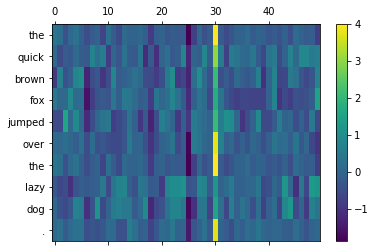

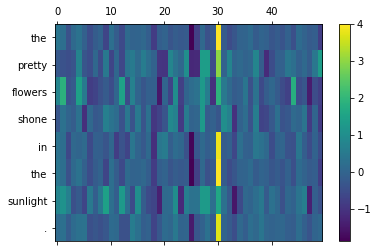

In [8]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [13]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'ENTAILMENT': 0,
      'NEUTRAL': 1,
      'CONTRADICTION': 2
    }
    score = np.zeros((3,))
    tag = row["entailment_judgment"]
    score[convert_dict[tag]] += 1
    return score

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

[Training data](http://www.site.uottawa.ca/~diana/csi5386/A2_2019/SICK_train.txt)

In [14]:
import numpy as np

def split_data_into_scores():
    import csv
    with open("training.txt","r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

In [29]:
tf.reset_default_graph()

In [30]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [31]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In [32]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

In [33]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:
    if i % 1000 == 0:
    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))


  0%|                                                                                                                                                                                   | 0/782 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 1.047516, Training Accuracy= 0.50781



  1%|█▌                                                                                                                                                                         | 7/782 [00:06<37:56,  2.94s/it]

Iter 10.0, Minibatch Loss= 1.006760, Training Accuracy= 0.51562



  2%|████▏                                                                                                                                                                     | 19/782 [00:06<13:02,  1.03s/it]

Iter 20.0, Minibatch Loss= 0.995709, Training Accuracy= 0.50781



  4%|██████▌                                                                                                                                                                   | 30/782 [00:06<04:39,  2.69it/s]

Iter 30.0, Minibatch Loss= 0.948813, Training Accuracy= 0.58594



  5%|████████▎                                                                                                                                                                 | 38/782 [00:07<02:26,  5.07it/s]

Iter 40.0, Minibatch Loss= 0.950432, Training Accuracy= 0.52344



  6%|██████████▊                                                                                                                                                               | 50/782 [00:07<01:05, 11.24it/s]

Iter 50.0, Minibatch Loss= 0.946411, Training Accuracy= 0.54688



  7%|████████████▌                                                                                                                                                             | 58/782 [00:07<00:43, 16.48it/s]

Iter 60.0, Minibatch Loss= 0.929457, Training Accuracy= 0.60938



  9%|███████████████▏                                                                                                                                                          | 70/782 [00:08<00:29, 24.00it/s]

Iter 70.0, Minibatch Loss= 0.933264, Training Accuracy= 0.61719



 10%|████████████████▉                                                                                                                                                         | 78/782 [00:08<00:29, 23.58it/s]

Iter 80.0, Minibatch Loss= 1.051194, Training Accuracy= 0.44531



 11%|███████████████████▎                                                                                                                                                      | 89/782 [00:08<00:24, 27.94it/s]

Iter 90.0, Minibatch Loss= 0.918972, Training Accuracy= 0.54688



 12%|█████████████████████                                                                                                                                                     | 97/782 [00:09<00:23, 28.65it/s]

Iter 100.0, Minibatch Loss= 0.991769, Training Accuracy= 0.52344



 14%|███████████████████████▌                                                                                                                                                 | 109/782 [00:09<00:21, 30.92it/s]

Iter 110.0, Minibatch Loss= 1.035804, Training Accuracy= 0.48438



 15%|█████████████████████████▎                                                                                                                                               | 117/782 [00:09<00:21, 30.36it/s]

Iter 120.0, Minibatch Loss= 0.899451, Training Accuracy= 0.58594



 16%|███████████████████████████▉                                                                                                                                             | 129/782 [00:10<00:20, 31.85it/s]

Iter 130.0, Minibatch Loss= 0.970988, Training Accuracy= 0.56250



 18%|█████████████████████████████▌                                                                                                                                           | 137/782 [00:10<00:19, 32.55it/s]

Iter 140.0, Minibatch Loss= 0.968313, Training Accuracy= 0.55469



 19%|████████████████████████████████▏                                                                                                                                        | 149/782 [00:10<00:20, 31.56it/s]

Iter 150.0, Minibatch Loss= 0.929391, Training Accuracy= 0.60938



 20%|█████████████████████████████████▉                                                                                                                                       | 157/782 [00:11<00:20, 30.04it/s]

Iter 160.0, Minibatch Loss= 0.989138, Training Accuracy= 0.48438



 21%|████████████████████████████████████                                                                                                                                     | 167/782 [00:11<00:21, 28.73it/s]

Iter 170.0, Minibatch Loss= 0.973588, Training Accuracy= 0.53125



 23%|██████████████████████████████████████▋                                                                                                                                  | 179/782 [00:11<00:19, 30.93it/s]

Iter 180.0, Minibatch Loss= 0.951481, Training Accuracy= 0.58594



 24%|████████████████████████████████████████▍                                                                                                                                | 187/782 [00:12<00:18, 32.17it/s]

Iter 190.0, Minibatch Loss= 1.005642, Training Accuracy= 0.51562



 25%|███████████████████████████████████████████                                                                                                                              | 199/782 [00:12<00:17, 33.81it/s]

Iter 200.0, Minibatch Loss= 0.959963, Training Accuracy= 0.55469



 26%|████████████████████████████████████████████▋                                                                                                                            | 207/782 [00:12<00:18, 31.94it/s]

Iter 210.0, Minibatch Loss= 0.986575, Training Accuracy= 0.55469



 28%|███████████████████████████████████████████████▎                                                                                                                         | 219/782 [00:13<00:16, 33.18it/s]

Iter 220.0, Minibatch Loss= 0.973009, Training Accuracy= 0.51562



 29%|█████████████████████████████████████████████████                                                                                                                        | 227/782 [00:13<00:17, 31.99it/s]

Iter 230.0, Minibatch Loss= 0.962127, Training Accuracy= 0.58594



 31%|███████████████████████████████████████████████████▋                                                                                                                     | 239/782 [00:13<00:16, 33.58it/s]

Iter 240.0, Minibatch Loss= 0.910340, Training Accuracy= 0.61719



 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 247/782 [00:14<00:16, 31.90it/s]

Iter 250.0, Minibatch Loss= 0.993861, Training Accuracy= 0.52344



 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 259/782 [00:14<00:15, 32.77it/s]

Iter 260.0, Minibatch Loss= 0.903926, Training Accuracy= 0.62500



 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 267/782 [00:14<00:19, 26.20it/s]

Iter 270.0, Minibatch Loss= 0.913727, Training Accuracy= 0.61719



 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 279/782 [00:15<00:16, 30.74it/s]

Iter 280.0, Minibatch Loss= 0.967694, Training Accuracy= 0.57812



 37%|██████████████████████████████████████████████████████████████                                                                                                           | 287/782 [00:15<00:15, 31.53it/s]

Iter 290.0, Minibatch Loss= 1.008206, Training Accuracy= 0.48438



 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 299/782 [00:15<00:15, 30.88it/s]

Iter 300.0, Minibatch Loss= 0.972587, Training Accuracy= 0.57031



 39%|██████████████████████████████████████████████████████████████████▎                                                                                                      | 307/782 [00:16<00:15, 31.48it/s]

Iter 310.0, Minibatch Loss= 0.915307, Training Accuracy= 0.60938



 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 319/782 [00:16<00:13, 33.08it/s]

Iter 320.0, Minibatch Loss= 0.978912, Training Accuracy= 0.56250



 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 327/782 [00:16<00:14, 32.00it/s]

Iter 330.0, Minibatch Loss= 0.898488, Training Accuracy= 0.60156



 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 339/782 [00:17<00:13, 32.89it/s]

Iter 340.0, Minibatch Loss= 0.889181, Training Accuracy= 0.62500



 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 347/782 [00:17<00:13, 31.21it/s]

Iter 350.0, Minibatch Loss= 0.927509, Training Accuracy= 0.59375



 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 359/782 [00:17<00:13, 32.14it/s]

Iter 360.0, Minibatch Loss= 0.990789, Training Accuracy= 0.53125



 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 367/782 [00:17<00:12, 32.67it/s]

Iter 370.0, Minibatch Loss= 0.945639, Training Accuracy= 0.56250



 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 379/782 [00:18<00:12, 32.19it/s]

Iter 380.0, Minibatch Loss= 0.898475, Training Accuracy= 0.60156



 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 387/782 [00:18<00:12, 30.83it/s]

Iter 390.0, Minibatch Loss= 0.960759, Training Accuracy= 0.55469



 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 399/782 [00:18<00:11, 32.51it/s]

Iter 400.0, Minibatch Loss= 0.964344, Training Accuracy= 0.57812



 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 407/782 [00:19<00:12, 30.31it/s]

Iter 410.0, Minibatch Loss= 0.970889, Training Accuracy= 0.56250



 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 419/782 [00:19<00:11, 30.86it/s]

Iter 420.0, Minibatch Loss= 0.997787, Training Accuracy= 0.53906



 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 427/782 [00:19<00:11, 31.77it/s]

Iter 430.0, Minibatch Loss= 0.895947, Training Accuracy= 0.61719



 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 439/782 [00:20<00:10, 31.53it/s]

Iter 440.0, Minibatch Loss= 1.001835, Training Accuracy= 0.50781



 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 447/782 [00:20<00:10, 32.27it/s]

Iter 450.0, Minibatch Loss= 0.914880, Training Accuracy= 0.55469



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 458/782 [00:20<00:11, 28.75it/s]

Iter 460.0, Minibatch Loss= 0.894183, Training Accuracy= 0.64062



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 469/782 [00:21<00:10, 30.63it/s]

Iter 470.0, Minibatch Loss= 0.929136, Training Accuracy= 0.54688



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 480/782 [00:21<00:10, 29.31it/s]

Iter 480.0, Minibatch Loss= 1.049858, Training Accuracy= 0.46875



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 487/782 [00:21<00:09, 29.65it/s]

Iter 490.0, Minibatch Loss= 0.965431, Training Accuracy= 0.57812



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 497/782 [00:22<00:10, 28.24it/s]

Iter 500.0, Minibatch Loss= 0.927769, Training Accuracy= 0.60938



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 509/782 [00:22<00:08, 30.70it/s]

Iter 510.0, Minibatch Loss= 0.999151, Training Accuracy= 0.53125



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 517/782 [00:22<00:08, 29.81it/s]

Iter 520.0, Minibatch Loss= 0.928518, Training Accuracy= 0.60156



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 529/782 [00:23<00:07, 31.89it/s]

Iter 530.0, Minibatch Loss= 0.952003, Training Accuracy= 0.55469



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 537/782 [00:23<00:08, 30.33it/s]

Iter 540.0, Minibatch Loss= 0.929418, Training Accuracy= 0.55469



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 549/782 [00:23<00:07, 31.57it/s]

Iter 550.0, Minibatch Loss= 0.943463, Training Accuracy= 0.59375



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 557/782 [00:24<00:07, 30.56it/s]

Iter 560.0, Minibatch Loss= 0.971188, Training Accuracy= 0.63281



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 569/782 [00:24<00:06, 31.12it/s]

Iter 570.0, Minibatch Loss= 1.115926, Training Accuracy= 0.31250



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 577/782 [00:24<00:06, 31.55it/s]

Iter 580.0, Minibatch Loss= 0.925274, Training Accuracy= 0.57812



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 589/782 [00:25<00:06, 32.14it/s]

Iter 590.0, Minibatch Loss= 0.980424, Training Accuracy= 0.53125



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 597/782 [00:25<00:05, 31.24it/s]

Iter 600.0, Minibatch Loss= 0.942857, Training Accuracy= 0.56250



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 608/782 [00:25<00:05, 29.23it/s]

Iter 610.0, Minibatch Loss= 0.942976, Training Accuracy= 0.51562



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 619/782 [00:26<00:05, 30.94it/s]

Iter 620.0, Minibatch Loss= 0.991773, Training Accuracy= 0.55469



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 630/782 [00:26<00:04, 30.65it/s]

Iter 630.0, Minibatch Loss= 0.922601, Training Accuracy= 0.59375



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 638/782 [00:26<00:04, 30.59it/s]

Iter 640.0, Minibatch Loss= 0.994773, Training Accuracy= 0.54688



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 649/782 [00:27<00:04, 29.83it/s]

Iter 650.0, Minibatch Loss= 0.974915, Training Accuracy= 0.54688



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 657/782 [00:27<00:04, 29.88it/s]

Iter 660.0, Minibatch Loss= 0.955971, Training Accuracy= 0.51562



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 668/782 [00:27<00:03, 28.55it/s]

Iter 670.0, Minibatch Loss= 1.001524, Training Accuracy= 0.50781



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 679/782 [00:28<00:03, 31.39it/s]

Iter 680.0, Minibatch Loss= 0.975385, Training Accuracy= 0.54688



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 687/782 [00:28<00:03, 31.64it/s]

Iter 690.0, Minibatch Loss= 0.960451, Training Accuracy= 0.53906



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 699/782 [00:28<00:02, 31.31it/s]

Iter 700.0, Minibatch Loss= 0.886937, Training Accuracy= 0.63281



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 707/782 [00:29<00:02, 31.75it/s]

Iter 710.0, Minibatch Loss= 0.906462, Training Accuracy= 0.59375



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 719/782 [00:29<00:01, 33.03it/s]

Iter 720.0, Minibatch Loss= 0.827357, Training Accuracy= 0.64844



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 727/782 [00:29<00:01, 32.97it/s]

Iter 730.0, Minibatch Loss= 0.990713, Training Accuracy= 0.53125



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 739/782 [00:30<00:01, 31.99it/s]

Iter 740.0, Minibatch Loss= 0.924678, Training Accuracy= 0.58594



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 747/782 [00:30<00:01, 31.32it/s]

Iter 750.0, Minibatch Loss= 0.916248, Training Accuracy= 0.60938



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 758/782 [00:30<00:00, 30.27it/s]

Iter 760.0, Minibatch Loss= 0.884754, Training Accuracy= 0.63281



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 770/782 [00:31<00:00, 31.57it/s]

Iter 770.0, Minibatch Loss= 0.995937, Training Accuracy= 0.50000



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 778/782 [00:31<00:00, 30.20it/s]

Iter 780.0, Minibatch Loss= 0.911700, Training Accuracy= 0.61719



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:31<00:00, 27.54it/s]

In [40]:
evidences = ["People wearing costumes are gathering in a forest and are looking in the same direction"]
hypotheses = ["Masked people are looking in the same direction in a forest"
]



sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]


import numpy as np

def split_data_into_scores():
    import csv
    with open("training.txt","r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
data_feature_list, correct_values, correct_scores = split_data_into_scores()




hyps, evis, ys = (data_feature_list[0][batch,:],
                  data_feature_list[1][batch,:],
                  correct_scores[batch])
predictions = sess.run(classification_scores, feed_dict={hyp: hyps, evi: evis, y: ys})
for i,prediction in enumerate(predictions):
    print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " / " + ["Positive", "Neutral", "Negative"][np.argmax(ys[i])])

0.607871
Positive / Positive
0.785411
Positive / Neutral
0.690139
Positive / Neutral
0.781037
Positive / Neutral
0.78575
Positive / Neutral
0.767756
Positive / Neutral
0.764161
Positive / Negative
0.622069
Positive / Neutral
0.595884
Positive / Neutral
0.773022
Positive / Positive
0.742922
Positive / Positive
0.786698
Positive / Negative
0.654095
Positive / Negative
0.784147
Positive / Neutral
0.787508
Positive / Neutral
0.707686
Positive / Positive
0.783017
Positive / Neutral
0.786039
Positive / Positive
0.785771
Positive / Positive
0.585391
Positive / Negative
0.583182
Positive / Neutral
0.787316
Positive / Neutral
0.773115
Positive / Positive
0.697083
Positive / Negative
0.613348
Positive / Positive
0.68538
Positive / Neutral
0.762156
Positive / Negative
0.781782
Positive / Positive
0.604864
Positive / Neutral
0.711201
Positive / Neutral
0.781985
Positive / Negative
0.758357
Positive / Negative
0.78385
Positive / Neutral
0.662126
Positive / Neutral
0.735227
Positive / Neutral
0.5833

In [ ]:
sess.close()